# 1. Grid search - iterating over hyperparameters

## Load libraries

In [1]:
# numpy
import numpy as np

# from scikit learn
from sklearn import datasets
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# TensorFlow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.optimizers import SGD, Adam

# scikeras wrapper
from scikeras.wrappers import KerasClassifier

2024-04-26 14:28:51.593369: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


__Load and preprocess MNIST data__

See Session 5 notebook for more details.

In [2]:
# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0)

__Initialise Gridsearch parameters__

In the following cell, we initialise our Logistic Regression model as ```pipe```.

We the make lists of possible values that can be assigned different values - for this, you should check the documentation over at sklearn.

In [3]:
# Initialise the default model, here given the name 'classifier'
pipe = Pipeline([('classifier' , LogisticRegression())])


# Set tunable parameters for grid search
penalties = ['l1', 'l2'] # different regularization parameters
C = [1.0, 0.1, 0.01]     # different regularization 'strengths'
solvers = ['liblinear']  # different solvers - check all of the sklearn docs

# Create parameter grid (a Python dictionary)
parameters = dict(classifier__penalty = penalties,  # notice how we use the name 'classifier'
                  classifier__C = C,
                  classifier__solver = solvers)

# Choose which metrics on which we want to optimise
scores = ['precision', 'recall', 'f1']

__Iterate over scoring types__

For example, we first optimise for the parameters which result in the best weighted precision score; next we optimse for weighted recall; and lastly for weighted-F1. 

This allows us to inspet the model in a more nuanced way, seeing how different parameters affect performance across different metrics.

In [4]:
for score in scores:
    print(f"# Tuning hyper-parameters for {score}")
    print()
    
    # Initialise Gridsearch with predefined parameters
    clf = GridSearchCV(pipe, 
                       parameters, 
                       scoring= f"{score}_weighted",
                       cv=10) # use 10-fold cross-validation
    # Fit
    clf.fit(X_train, y_train)
    
    # Print best results on training data
    print("Best parameters set found on training data:")
    # add new lines to separate rows
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on training data:")
    print()
    # get all means
    means = clf.cv_results_['mean_test_score']
    # get all standard deviations
    stds = clf.cv_results_['std_test_score']
    # get parameter combinations
    params = clf.cv_results_['params']

    # print means, standard deviations , and parameters for all runs
    i = 0
    for mean, stdev, param in zip(means, stds, params):
        # 2*standard deviation covers 95% of the spread - check out the 68–95–99.7 rule
        print(f"Run {i}: {round(mean,3)} (SD=±{round(stdev*2, 3)}), using {param}")
        i += 1
    print()
    
    # Print details classification report
    print("Detailed classification report:")
    print()
    print("The model is trained on the full training set.")
    print("The scores are computed on the full test set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on training data:

{'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Grid scores on training data:

Run 0: 0.966 (SD=±0.019), using {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Run 1: 0.966 (SD=±0.022), using {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Run 2: 0.971 (SD=±0.024), using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Run 3: 0.97 (SD=±0.019), using {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Run 4: 0.933 (SD=±0.045), using {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Run 5: 0.969 (SD=±0.019), using {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Detailed classification report:

The model is trained on the full training set.

## More complex DL models

The same general pipeline can be applied to more complex deep learning models, such as those using CNNs or similar.

To do this, we have to define our model using ```tf.keras``` in a slightly different way from what we are used to.

__Inspect image shapes for input layer size__

In [5]:
X[0].shape

(64,)

__Define model__

We begin by defining our model, almost the same as we normally would. The main difference is that we wrap the whole thign in a function definition, which we've here called ```nn_model```.

In [8]:
def nn_model(optimizer='adam'):
    # create a sequential model
    model = Sequential()
    # add input layer of 64 nodes and hidden layer of 32, ReLU activation
    model.add(InputLayer(shape=(64,)))
    model.add(Dense(32, 
                    activation="relu"))
    # hidden layer of 16 nodes, ReLU activation
    model.add(Dense(16, 
                    activation="relu"))
    # classificaiton layer, 10 classes with softmaxa ctivation
    model.add(Dense(10, 
                    activation="softmax")) 
    # categorical cross-entropy, optimizer defined in function call
    model.compile(loss="categorical_crossentropy", 
                  optimizer=optimizer, 
                  metrics=["accuracy"])

    # return the compiled model
    return model

__Create model for ```sklearn```__

We take the predefined neural network model above and run it through ```KerasClassifier```. 

This returns an object that can be used in the ```sklearn``` pipeline, just like a ```LogisticRegression()``` classifier, for example.

In [9]:
model = KerasClassifier(model=nn_model, # build the model defined in nn_model
                        verbose=0)         # set to 1 for verbose output during training

__Define grid search parameters__

We now define our grid search parameters in exactly the same manner as we did above.

In [10]:
# grid search epochs, batch size and optimizer
optimizers = ['sgd', 'adam']
# range of epochs to run
epochs = [5, 10]
# variable batch sizes
batches = [5, 10]

# create search grid
param_grid = dict(optimizer=optimizers, 
                  epochs=epochs, 
                  batch_size=batches)

__Initialise Gridsearch with model and parameter grid__

We then run grid search using these parameters and the neural network model that we defined.

In [11]:
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1,    # number of CPU cores to use: -1 means use all available
                    cv=5,         # 5-fold cross validation
                    scoring='accuracy',
                    verbose=3)

__Fit to the data and labels__

In [12]:
# create one-hot encodings
lb = LabelBinarizer()
y = lb.fit_transform(y)

In [13]:
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


2024-04-26 14:42:20.989669: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 14:42:20.991521: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 14:42:21.013748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 14:42:21.013747: I tensorflow

[CV 3/5] END batch_size=5, epochs=5, optimizer=adam;, score=0.897 total time=   8.1s
[CV 2/5] END batch_size=5, epochs=5, optimizer=adam;, score=0.908 total time=   8.2s
[CV 1/5] END batch_size=5, epochs=5, optimizer=sgd;, score=0.931 total time=   8.2s
[CV 2/5] END batch_size=5, epochs=5, optimizer=sgd;, score=0.853 total time=   8.3s
[CV 1/5] END batch_size=5, epochs=5, optimizer=adam;, score=0.908 total time=   8.3s
[CV 5/5] END batch_size=5, epochs=5, optimizer=sgd;, score=0.855 total time=   8.3s
[CV 4/5] END batch_size=5, epochs=5, optimizer=sgd;, score=0.936 total time=   8.4s
[CV 3/5] END batch_size=5, epochs=5, optimizer=sgd;, score=0.900 total time=   8.4s
[CV 5/5] END batch_size=5, epochs=5, optimizer=adam;, score=0.883 total time=   8.2s
[CV 4/5] END batch_size=5, epochs=5, optimizer=adam;, score=0.942 total time=   8.4s
[CV 2/5] END batch_size=5, epochs=10, optimizer=sgd;, score=0.889 total time=  14.5s
[CV 5/5] END batch_size=5, epochs=10, optimizer=sgd;, score=0.894 tota

__Print best results__

The following cell prints the parameters which return the best possible model from all combinations.

In [14]:
# print best results, rounding values to 3 decimal places
print(f"Best run: {round(grid_result.best_score_,3)} using {grid_result.best_params_}")

Best run: 0.923 using {'batch_size': 5, 'epochs': 10, 'optimizer': 'adam'}


__Show all runs__

We can also inspect all runs, in order to see if there are general tendencies or patterns.

In [15]:
# get all means
means = grid_result.cv_results_['mean_test_score']
# get all standard deviations
stds = grid_result.cv_results_['std_test_score']
# get parameter combinations
params = grid_result.cv_results_['params']

# print means, standard deviations, and parameters for all runs
i = 0
for mean, stdev, param in zip(means, stds, params):
    print(f"Run {i}: {round(mean,3)} (SD=±{round(2*stdev, 3)}), using {param}")
    i += 1

Run 0: 0.895 (SD=±0.071), using {'batch_size': 5, 'epochs': 5, 'optimizer': 'sgd'}
Run 1: 0.908 (SD=±0.039), using {'batch_size': 5, 'epochs': 5, 'optimizer': 'adam'}
Run 2: 0.917 (SD=±0.045), using {'batch_size': 5, 'epochs': 10, 'optimizer': 'sgd'}
Run 3: 0.923 (SD=±0.046), using {'batch_size': 5, 'epochs': 10, 'optimizer': 'adam'}
Run 4: 0.891 (SD=±0.038), using {'batch_size': 10, 'epochs': 5, 'optimizer': 'sgd'}
Run 5: 0.874 (SD=±0.058), using {'batch_size': 10, 'epochs': 5, 'optimizer': 'adam'}
Run 6: 0.916 (SD=±0.062), using {'batch_size': 10, 'epochs': 10, 'optimizer': 'sgd'}
Run 7: 0.906 (SD=±0.073), using {'batch_size': 10, 'epochs': 10, 'optimizer': 'adam'}


# 2. Visualise feature maps

A useful task in the context of visual anlaytics and Convolutional Neural Networks is the idea of visualising feature maps. In other words, can we see what a model is actually 'looking' at?

One way to do this is to use an activation heatmap, to show which areas draw the most 'focus' from a model when classifying.

In [16]:
# path tools
import sys,os
sys.path.append("..")
# neural networks with numpy
from utils.imutils import jimshow as show

# image processing
import numpy as np
import matplotlib.pyplot as plt
import cv2

# tensorflow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)

__Import VGG16 model__

We're choosing here to work with VGG16 but the same principle can be applied to other pretrained models, or your own models. The only thing that will need to be changed is the name of the final convolutional layer.

In [17]:
model = VGG16()

model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

__Load image__

We can choose to load an image - look back to the last few weeks to check up on how to load images with ```tf.keras```. Remember that your image needs to be the same dimensions as the pretrained model!

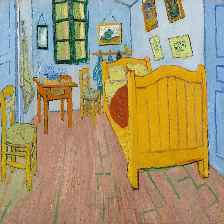

In [37]:
# file path - hard coded paths are bad practice!
filepath = os.path.join("..", "..", "..", "..", "..", "cds-vis-data", "data","img", "the_bedroom.jpg")

# load image using tf.keras
img = image.load_img(filepath, target_size=(224, 224))

# display image
img

__Preprocess and predict__

See Session 10 notebook for more information.

In [38]:
# convert image to array
x = image.img_to_array(img)
# convert to rank 4 tensor
x = np.expand_dims(x, axis=0)
# preprocess to be in line with VGG16 data 
x = preprocess_input(x)

# make predictions
preds = model.predict(x)
decode_predictions(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


[[('n03598930', 'jigsaw_puzzle', 0.5185097),
  ('n03930313', 'picket_fence', 0.042194277),
  ('n03733281', 'maze', 0.041414186),
  ('n04209239', 'shower_curtain', 0.030867798),
  ('n02843684', 'birdhouse', 0.01894603)]]

__Create activation heatmap for final layer__

In order to visualise the layers, we use something called **[Gradient-weighted Class Activation Mapping (Grad-CAM)](https://arxiv.org/pdf/1610.02391.pdf)**. 

Essentially, we make use of the gradients in the final layer to highlight which regions are particularly informative when predicting a given class.

The code here is a little complicated to follow - you can find more info [here](https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/) and [here](https://www.tensorflow.org/guide/autodiff).

The code below has been modified from Keras documentation, found [here](https://keras.io/examples/vision/grad_cam/).

In [39]:
with tf.GradientTape() as tape:
    # make sure the name here corresponds to the final conv layer in your network
    last_conv_layer = model.get_layer('block5_conv3')
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions    
    iterate = tf.keras.models.Model(model.inputs, 
                                    [model.output, last_conv_layer.output])
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    
    # This is the gradient of the output neuron of the last conv layer
    grads = tape.gradient(class_out, 
                          last_conv_layer)
    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, 
                          axis=(0, 1, 2))

In [40]:
# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), 
                         axis=-1)

__Simple heatmap using matplotlib__

We can then create a very simple heatmap showing where 'attention' is focused in the final layer when predicting our input image.

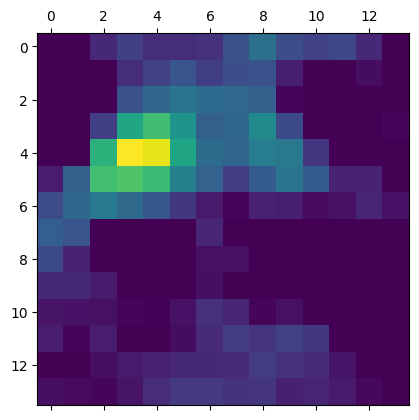

In [41]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((14, 14))
plt.matshow(heatmap)
plt.show()

__Better visualisation with ```OpenCV```__

In [42]:
# Load the original image
img = cv2.imread(filepath)

# heatmap should be semi transparent
intensity = 0.5

# resize the heatmap to be the original dimensions of the input 
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# https://docs.opencv.org/master/d3/d50/group__imgproc__colormap.html
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

# multiply heatmap by intensity and 'add' this on top of the original image
superimposed = (heatmap * intensity) + img

__Write file to output__

I've created a new folder called maps_out where I save the image.

In [43]:
cv2.imwrite("the_bedroom.jpg", superimposed)

True